## EDA

In [208]:
from __future__ import division
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle

In [224]:
# Files that contain extracted names and summaries
sample10_file = '/Users/lekha/galvanize/capstone/projectRiley/data/sample10/out.txt'
sample1000_file = '/Users/lekha/galvanize/capstone/projectRiley/data/out1000.txt'
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/out.txt'

In [210]:
pwd

u'/Users/lekha/galvanize/capstone/projectRiley/code'

In [297]:
cols = defaultdict(list)
num_rows = 0
with open(sample1000_file) as f:
    for line in f:
        num_rows += 1
        n = line.split('||')
        print n[0]
        cols['full_name'].append(n[0])
        cols['summary'].append(n[1])
        cols['html'].append(n[2])

df = pd.DataFrame(data=cols, index = np.arange(num_rows))

ben berkman
john cook phd
aakash maniyar
aaron buckner
aaron hawley
aaron schlegel
abhishek gupta
adam markus
aditya gandhi
aditya hrishikesh
adrian matias
adrianne m grondahl
jeffrey portko
amir hossein maleki
austin krause ruthruff
alan boss
alex gross
alex gallo
alexandra sanchez
alex bash
alex bu
alexis johnston
alex webster
alex withrow
alan horowitz
alice hahn
alice yao
alicia moreno gonzalez
aliette frank
alina huldtgren
alison driver
alison wilbur
allan luik
allison kelsey
allison m fitzgerald
alyson jones
alyssa thurston
amanda e b bryan phd
amanda widjaja
ambrogino giusti
amelia mattocks
amira djebbari
amy flores
amy lovelace
amy kelley
amy summe
ande flower
andrea b freed phd
andrea caputo
andr dan
andre mueller
andy bury
andy ernst
andy oconnell
angela ohnmar duong
angela marks
angie leonard
anita griner mba pmp
anna fero
annemarie marshalldody pwm cfm
 an nguyen
m mccarthy
anthony billones
anton coleman
anthony smith ma
antti teli
anupam biswas mba cisa pass
anushree baner

In [301]:
# Add new column for first_name
df['first_name'] = df['full_name'].apply(lambda x: x.split()[0])

In [302]:
df = df[df['first_name'] != 'missing']

In [303]:
df = df[df['first_name'] != 'unicode-only']

In [304]:
df = df[df['first_name'].map(len) > 1]

In [345]:
len(df)

995

In [346]:
# add a counter of ones for doing some data analysis
df['counter'] = np.ones(len(df))

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 1002
Data columns (total 6 columns):
full_name     995 non-null object
html          995 non-null object
summary       995 non-null object
first_name    995 non-null object
gender        995 non-null object
counter       995 non-null float64
dtypes: float64(1), object(5)
memory usage: 54.4+ KB


In [205]:
df['summ_missing'] = 0

## Gender Prediction using First Names

In [306]:
def gender_features(word):
    '''
    Returns the following features given a word:
    - name
    - last letter
    - last 2 letters
    - boolean if last letter is vowel
    '''
    return {'name': word, 'last_letter': word[-1], 'last_2_letters': word[-2:], 'last_is_vowel': (word[-1] in 'aeiou')}

In [374]:
def force_names(name, gender):
    females = ['jennifer', 'mary', 'nancy', 'kimberly', 'lauren', 'sarah', 'heather', 'susan', 'amy', 'kim']
    males = ['dave','mike', 'steve','kyle', 'aditya']
    if name in females:
        return 'female'
    if name in males:
        return 'male'
    return gender

In [375]:
import nltk
from nltk.corpus import names

def gender_classifier(first_name):
    # 7944 labeled names from nltk corpus
    labeled_names = ([(name, 'male') for name in names.words('male.txt')] +[(name, 'female') for name in names.words('female.txt')])

    # nltk's NaiveBayesClassifier takes featuresets to train that is a tuple of (features_dict, label)
    featuresets_train = [(gender_features(name), gender) for (name, gender) in labeled_names]
    classifier = nltk.NaiveBayesClassifier.train(featuresets_train)
    
    # get the features of the set to be classified
    name_features = gender_features(first_name)
    g = classifier.classify(name_features)

    g = force_names(first_name, g)
    
    return g


df['gender'] = df['first_name'].apply(lambda x: gender_classifier(x))

In [314]:
# Write DF with gender to a text file
df.to_csv('../data/cleandatagender.txt', sep="|")

In [145]:
# Verification Cell for Classification Algorithm
#train_set, test_set = featuresets[600:], featuresets[:500]
print classifier.classify(gender_features('rahul'))
print classifier.classify(gender_features('Trinity'))
print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(5)

male
male
0.802
Most Informative Features
          last_2_letters = u'na'          female : male   =    106.4 : 1.0
          last_2_letters = u'la'          female : male   =     80.2 : 1.0
          last_2_letters = u'ia'          female : male   =     42.4 : 1.0
          last_2_letters = u'sa'          female : male   =     37.8 : 1.0
             last_letter = u'a'           female : male   =     35.4 : 1.0


In [369]:
df_agg = df.groupby(['gender','first_name']).agg({'counter':sum})

In [370]:
#group by the first level of the index
g = df_agg['counter'].groupby(level=0, group_keys=False)

In [379]:
df['first_name'].nunique()

565

In [372]:
# sort by the count of the first names
g.nlargest(30)

gender  first_name 
female  mary           11
        jennifer        7
        laura           7
        nancy           7
        jessica         6
        kimberly        6
        lauren          6
        michelle        6
        susan           6
        diana           5
        heather         5
        melissa         5
        sarah           5
        stephanie       5
        christina       4
        erica           4
        julie           4
        tara            4
        amanda          3
        christine       3
        kara            3
        katie           3
        patricia        3
        rebecca         3
        vanessa         3
        alice           2
        andrea          2
        angela          2
        carla           2
        claire          2
male    michael        20
        david          15
        john           14
        christopher     9
        ryan            9
        brian           8
        jeff            8
        scott     

In [58]:
x = zip(fnames, gender_fnames1)
with open('gender1000.txt', 'w') as f:
    for line in x:
        name = line[0]
        g = line[1]
        nameg = name + "," + g + "\n"
        f.write(nameg)
        #f.write("\n")

In [160]:
letter_freq = df.last_letter.value_counts()
letter_freq.sort_values(ascending=False, inplace=True)


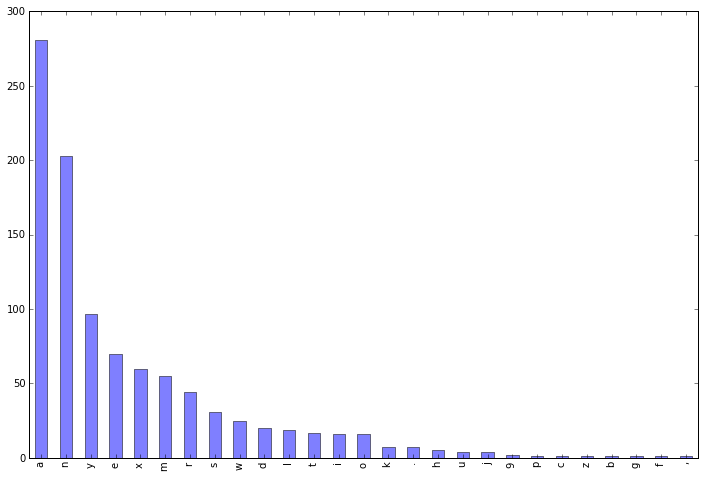

In [161]:
# Plot one of the features for gender prediction: last letter
fig, ax = plt.subplots()
letter_freq.plot(ax=ax, kind='bar', alpha = 0.5, figsize=(12,8))